###1. Download and Install necessary packages

In [ ]:
!pip install vllm

In [ ]:
!pip install trl==0.14.0 datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: dill
    Found existing installation: dill 0.4.0
    Uninstalling dill-0.4.0:
      Successfully uninstalled dill-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==202

In [ ]:
import os
import re
import torch
import numpy as np
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from trl import GRPOConfig, GRPOTrainer
from google.colab import files, drive
from peft import LoraConfig


# Define System Prompt
SYSTEM_PROMPT = """
You will be given a question. What you have to do is generate your answer by strictly following the below instructions,
First identify the goal and wrap it inside <goal_detector>...</goal_detector>tags.
Then generate the step wise plan (with numeric calculation if needed) to achieve the goal (solve the question), and wrap it inside <plan_generator>....</plan_generator> tags.
Then decide what will happen if you execute the above plan, and wrap it inside <projector>....</projector> tags.
Finally wrap your final answer inside <executer>...</executer> tags.

Your final answer must be in the below format,
<goal_detector>
........
</goal_detector>
<plan_generator>
........
</plan_generator>
<projector>
........
</projector>
<executer>
........
</executer>
Make sure to include all the 8 opening and closing tags in your final answer.
"""

INFO 04-21 04:01:28 [__init__.py:239] Automatically detected platform cuda.


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


###2. Load Training Dataset

In [ ]:
def extract_xml_answer(text: str) -> str:
    answer = text.split("<executer>")[-1]
    answer = answer.split("</executer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split]
    data = data.map(lambda x: {
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    })
    return data

dataset = get_gsm8k_questions()
dataset = dataset.select(range(1000))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

###3. Defining reward Functions

In [ ]:
# Reward functions - Structural Relavance
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [5.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<goal_detector>\n.*?\n</goal_detector>\n<plan_generator>\n.*?\n</plan_generator>\n<projector>\n.*?\n</projector>\n<executer>\n.*?\n</executer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [7 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<goal_detector>.*?</goal_detector>\s*<plan_generator>.*?</plan_generator>\s*<projector>.*?</projector>\s*<executer>.*?</executer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [5 if match else 0.0 for match in matches]

In [ ]:
# Load the trained reward model
model_path = "/content/drive/My Drive/reward_model"
reward_model = AutoModelForSequenceClassification.from_pretrained(model_path)
reward_tokenizer = AutoTokenizer.from_pretrained(model_path)

uncertainty_cache = {}
reward_model.train()
device = torch.device("cuda")
reward_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

#####3.1 Uncertainty Reward Mechanism

In [ ]:
def compute_fisher_information(model, inputs):
    """ Computes Fisher Information and returns both Fisher Approximation and gradients. """
    # Forward pass
    outputs = model(**inputs).logits
    loss = outputs.mean()

    # Computing first-order gradients
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Computing Fisher Information (diagonal approximation)
    fisher_diag = [g**2 + 1e-6 for g in grads]  # Adding small noise for stability

    return fisher_diag, grads

def compute_uncertainty(model, inputs, fisher_diag, grads):
    """ Computes uncertainty using Fisher Information, but reuses gradients from Fisher computation. """
    inputs_key = tuple(inputs["input_ids"].cpu().numpy().flatten())

    if inputs_key in uncertainty_cache:
        return uncertainty_cache[inputs_key]

    # Using precomputed gradients instead of recomputing them
    uncertainty = sum((g * f * g).sum() for g, f in zip(grads, fisher_diag))  # Element-wise multiplication

    uncertainty_cache[inputs_key] = uncertainty.item()
    return uncertainty.item()

def test_reward_model_with_posterior(prompts, completions, **kwargs):
    """ Encodes input text, runs inference, and applies Bayesian posterior adjustment using Fisher Approximation. """

    sampled_rewards = []

    for prompt, completion in zip(prompts, completions):
        response = completion[0]['content']
        instruction = prompt[-1]['content']

        input_text = instruction + "\n" + response
        inputs = reward_tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Computing reward score
        with torch.no_grad():
            outputs = reward_model(**inputs)
        reward_score = outputs.logits.item()

        # Computing Fisher Information approximation + Get Gradients
        fisher_matrix, fisher_grads = compute_fisher_information(reward_model, inputs)

        # Computing cached uncertainty from Fisher Information using precomputed gradients
        ts_uncertainty = compute_uncertainty(reward_model, inputs, fisher_matrix, fisher_grads)

        # Preventing exploding uncertainties
        safe_uncertainty = min(max(ts_uncertainty, 1e-6), 10.0)  # Capping uncertainty for stability

        # Applying Thompson Sampling: Sample from the posterior
        std_dev = min(np.sqrt(safe_uncertainty), 2.0)  # Clamping standard deviation
        sampled_reward = float(np.clip(np.random.normal(reward_score, std_dev), 0, 7))
        sampled_rewards.append(sampled_reward)

        print("\n==============================================")
        print(f"🔹 Instruction: {instruction}")
        print(f"🔹 Response: {response}")
        print(f"🎯 Raw Reward: {reward_score:.5f} | 🎲 Uncertainty: {ts_uncertainty:.5f} | 🏆 Sampled Reward: {sampled_reward:.5f}")
        print("==============================================\n")

    return sampled_rewards

###4. Hyperparameter Tuning

In [ ]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

output_dir="outputs/Qwen-1.5B-GRPO"
run_name="Qwen-1.5B-GRPO-gsm8k"

training_args = GRPOConfig(
    output_dir=output_dir,
    run_name=run_name,
    learning_rate=0.0001,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type='cosine_with_restarts',
    logging_steps=1,
    bf16=True,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_generations=2,
    max_prompt_length=512,
    max_completion_length=512,
    num_train_epochs=3,
    save_steps=100,
    max_grad_norm=0.1,
    log_on_each_node=False,
    temperature=0.1,
    report_to="none"
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=None
).to("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
# Lora Configs
peft_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    lora_dropout=0.1,
)

# Model Training
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
        test_reward_model_with_posterior],
    args=training_args,
    train_dataset=dataset,
    peft_config=peft_config
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


-------------------- Question:
Every day, Sara bakes 10 cakes and puts them in his refrigerator. He does this for 5 days. Carol then comes over and eats 12 of his cakes. If it takes 2 cans of frosting to frost a single cake, how many cans of frosting does Bob need to frost the remaining cakes? 
Answer:
76 
Response:
<goal_detector>
Sara bakes 10 cakes every day for 5 days, Carol eats 12 of them, and we need to calculate the number of cans of frosting needed to frost the remaining cakes.
</goal_detector>
<plan_generator>
1. Calculate the total number of cakes baked by Sara: 10 cakes/day * 5 days = 50 cakes.
2. Subtract the number of cakes eaten by Carol from the total number of cakes baked: 50 cakes - 12 cakes = 38 cakes.
3. Calculate the number of cans of frosting needed to frost the remaining cakes: 38 cakes * 2 cans/cake = 76 cans.
</plan_generator>
<projector>
Sara bakes a total of 50 cakes, and after Carol eats 12 of them, 38 cakes remain. To frost these remaining cakes, Bob needs 

Step,Training Loss
1,0.000000
2,-0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000100
9,0.000200
10,0.000200


Streaming output truncated to the last 5000 lines.

🔹 Instruction: James is a first-year student at a University in Chicago. He has a budget of $1000 per semester. He spends 30% of his money on food, 15% on accommodation, 25% on entertainment, and the rest on coursework materials. How much money does he spend on coursework materials?
🔹 Response: <goal_detector>
James has a budget of $1000 per semester. He spends 30% on food, 15% on accommodation, 25% on entertainment, and the rest on coursework materials. We need to calculate how much money he spends on coursework materials.
</goal_detector>

<plan_generator>
1. Calculate the amount spent on food: $1000 * 30% = $300
2. Calculate the amount spent on accommodation: $1000 * 15% = $150
3. Calculate the amount spent on entertainment: $1000 * 25% = $250
4. Calculate the amount spent on coursework materials: $1000 - ($300 + $150 + $250) = $1000 - $700 = $300
</plan_generator>

<projector>
James spends $300 on coursework materials.
</projector

Step,Training Loss
1,0.000000
2,-0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000100
9,0.000200
10,0.000200


Streaming output truncated to the last 5000 lines.
</goal_detector>
<plan_generator>
1. Calculate the amount James received from selling his car: 
   $20,000 * 80% = $16,000
2. Calculate the amount James paid for the new car: 
   $30,000 * 90% = $27,000
3. Calculate the total amount James was out of pocket: 
   $16,000 - $27,000 = -$11,000
</plan_generator>
<projector>
James was out of pocket $11,000.
</projector>
<executer>
</executer>
🎯 Raw Reward: 5.70357 | 🎲 Uncertainty: 232.44817 | 🏆 Sampled Reward: 4.83582


🔹 Instruction: James decides to replace his car.  He sold his $20,000 car for 80% of its value and then was able to haggle to buy a $30,000 sticker price car for 90% of its value.  How much was he out of pocket?
🔹 Response: <goal_detector>
James sold his car for 80% of its value and then bought a new car for 90% of its value.
</goal_detector>
<plan_generator>
1. Calculate the amount James received from selling his car: 
   $20,000 * 80% = $16,000
2. Calculate the amount James

TrainOutput(global_step=186, training_loss=0.0012644089687973877, metrics={'train_runtime': 22126.0317, 'train_samples_per_second': 0.136, 'train_steps_per_second': 0.008, 'total_flos': 0.0, 'train_loss': 0.0012644089687973877})

###5. Plotting Evaluation Metrices

In [ ]:
import matplotlib.pyplot as plt

# Extracting loss values
logs = trainer.state.log_history

[{'loss': 0.0, 'grad_norm': 0.07196278870105743, 'learning_rate': 0.0, 'completion_length': 211.84375, 'rewards/soft_format_reward_func': 0.0, 'rewards/strict_format_reward_func': 0.0, 'rewards/int_reward_func': 0.109375, 'rewards/correctness_reward_func': 1.09375, 'reward': 1.203125, 'reward_std': 0.729203850030899, 'kl': 0.0, 'epoch': 0.016, 'step': 1}, {'loss': 0.0, 'grad_norm': 0.06690263003110886, 'learning_rate': 5.263157894736842e-06, 'completion_length': 209.0, 'rewards/soft_format_reward_func': 0.0, 'rewards/strict_format_reward_func': 0.0, 'rewards/int_reward_func': 0.046875, 'rewards/correctness_reward_func': 0.15625, 'reward': 0.203125, 'reward_std': 0.24306795001029968, 'kl': 0.0, 'epoch': 0.032, 'step': 2}, {'loss': 0.0, 'grad_norm': 0.045102473348379135, 'learning_rate': 1.0526315789473684e-05, 'completion_length': 225.3125, 'rewards/soft_format_reward_func': 0.0, 'rewards/strict_format_reward_func': 0.0, 'rewards/int_reward_func': 0.15625, 'rewards/correctness_reward_fu

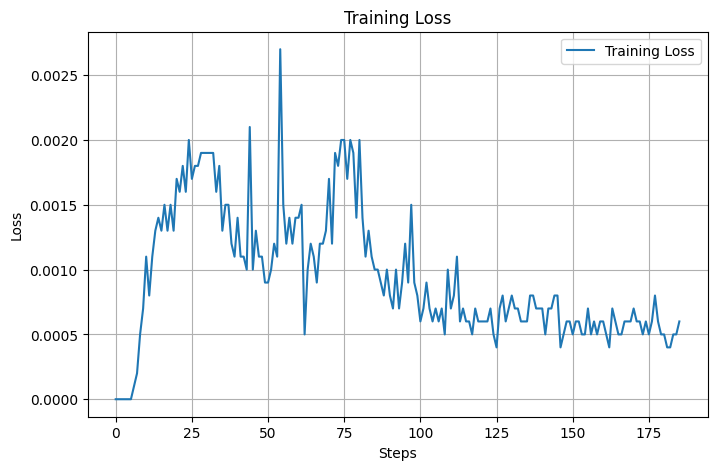

In [ ]:
print(logs)
train_losses = [log["loss"] for log in logs if "loss" in log]

# Generating x-axis values
steps = list(range(len(train_losses)))

# Plotting Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(steps, train_losses, label="Training Loss")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid()
plt.show()

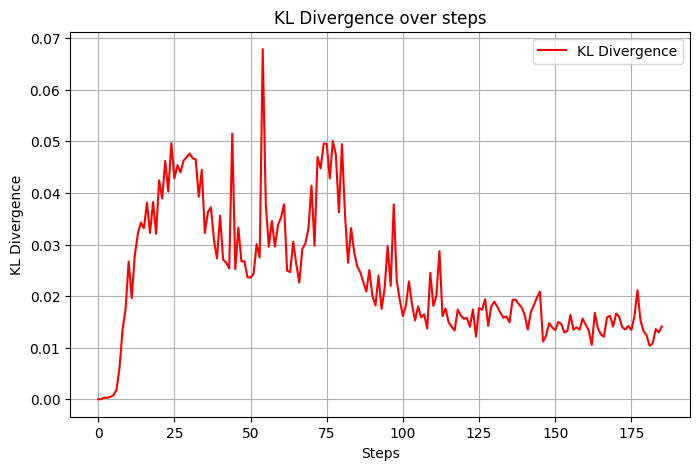

In [ ]:
kl = [log["kl"] for log in logs if "kl" in log]

# Generate x-axis values
steps = list(range(len(kl)))

# Plotting KL Divergence
plt.figure(figsize=(8, 5))
plt.plot(steps, kl, label="KL Divergence", color="red")

plt.xlabel("Steps")
plt.ylabel("KL Divergence")
plt.title("KL Divergence over steps")
plt.legend()
plt.grid()
plt.show()

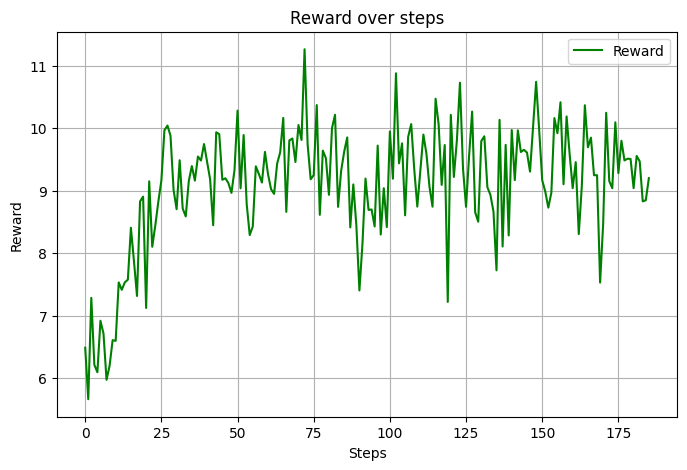

In [ ]:
reward = [log["reward"] for log in logs if "reward" in log]

# Generate x-axis values
steps = list(range(len(reward)))

# Plotting overall reward distribution
plt.figure(figsize=(8, 5))
plt.plot(steps, reward, label="Reward", color="green")

plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Reward over steps")
plt.legend()
plt.grid()
plt.show()

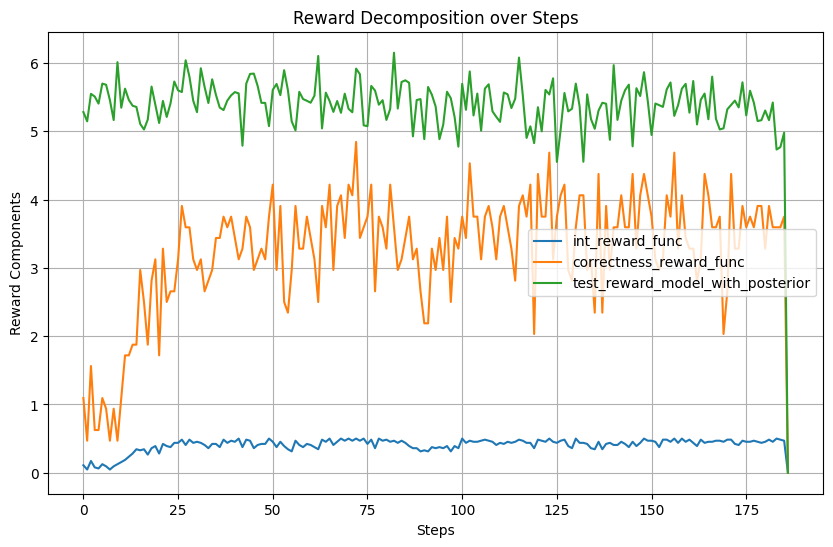

In [ ]:
components = ["rewards/int_reward_func", "rewards/correctness_reward_func", "rewards/test_reward_model_with_posterior"]
rewards_dict = {k: [log.get(k, 0.0) for log in logs] for k in components}
steps = list(range(len(logs)))

# Plotting eachreward
plt.figure(figsize=(10, 6))
for k, v in rewards_dict.items():
    plt.plot(steps, v, label=k.split("/")[-1])

plt.xlabel("Steps")
plt.ylabel("Reward Components")
plt.title("Reward Decomposition over Steps")
plt.legend()
plt.grid()
plt.show()

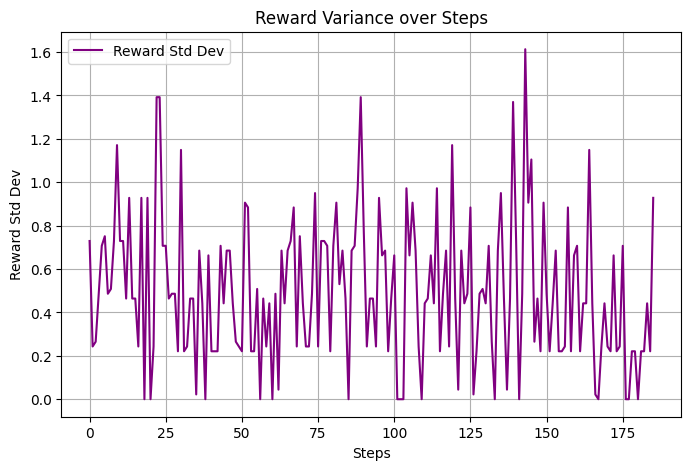

In [ ]:
reward_std = [log["reward_std"] for log in logs if "reward_std" in log]
steps = list(range(len(reward_std)))

# Plotting Reward Variance
plt.figure(figsize=(8, 5))
plt.plot(steps, reward_std, label="Reward Std Dev", color="purple")

plt.xlabel("Steps")
plt.ylabel("Reward Std Dev")
plt.title("Reward Variance over Steps")
plt.legend()
plt.grid()
plt.show()

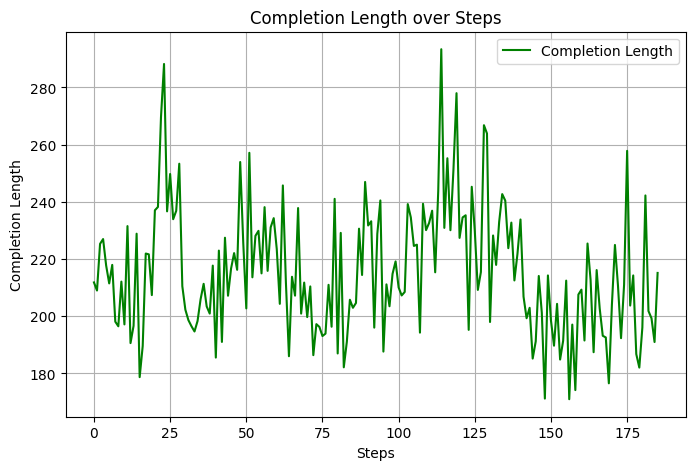

In [ ]:
completion_length = [log["completion_length"] for log in logs if "completion_length" in log]
steps = list(range(len(completion_length)))

# Plotting Completion Length over Steps
plt.figure(figsize=(8, 5))
plt.plot(steps, completion_length, label="Completion Length", color="green")

plt.xlabel("Steps")
plt.ylabel("Completion Length")
plt.title("Completion Length over Steps")
plt.legend()
plt.grid()
plt.show()

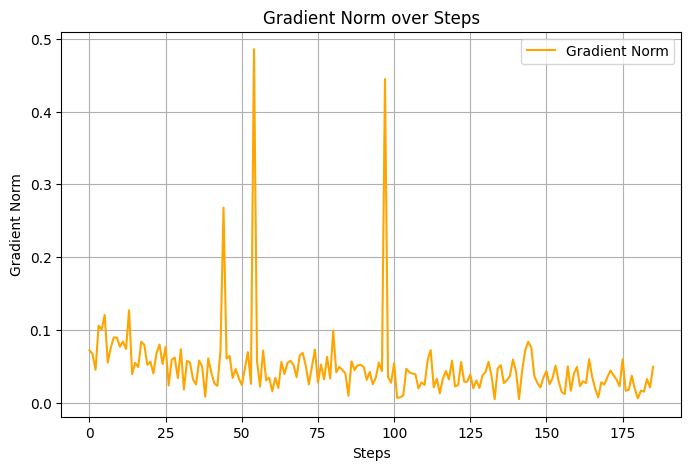

In [ ]:
grad_norm = [log["grad_norm"] for log in logs if "grad_norm" in log]
steps = list(range(len(grad_norm)))

# Plotting Gradient Normalization
plt.figure(figsize=(8, 5))
plt.plot(steps, grad_norm, label="Gradient Norm", color="orange")

plt.xlabel("Steps")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm over Steps")
plt.legend()
plt.grid()
plt.show()

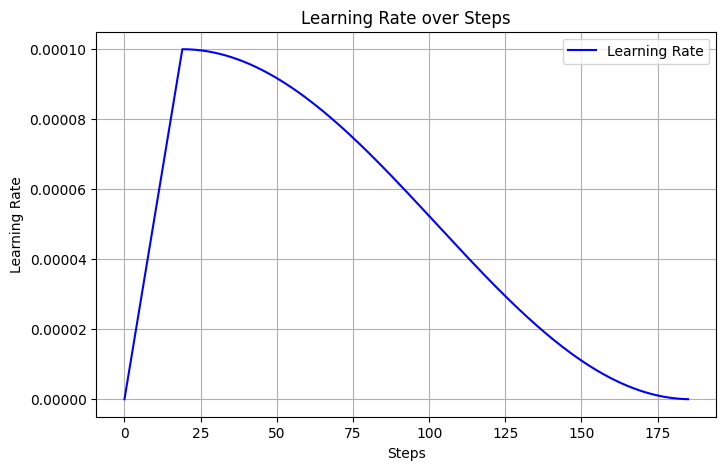

In [ ]:
learning_rate = [log["learning_rate"] for log in logs if "learning_rate" in log]
steps = list(range(len(learning_rate)))

# Plotting Learning Rate
plt.figure(figsize=(8, 5))
plt.plot(steps, learning_rate, label="Learning Rate", color="blue")

plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate over Steps")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Saving the model
drive_save_path = "/content/drive/My Drive/base_model_v3"
os.makedirs(drive_save_path, exist_ok=True)
trainer.save_model(drive_save_path)
tokenizer.save_pretrained(drive_save_path)

('/content/drive/My Drive/base_model_v3/tokenizer_config.json',
 '/content/drive/My Drive/base_model_v3/special_tokens_map.json',
 '/content/drive/My Drive/base_model_v3/vocab.json',
 '/content/drive/My Drive/base_model_v3/merges.txt',
 '/content/drive/My Drive/base_model_v3/added_tokens.json',
 '/content/drive/My Drive/base_model_v3/tokenizer.json')